## Import Packages

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
import re
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pickle
from torchvision import transforms
import random
import warnings

!pip install mtcnn
!pip install --no-cache-dir lz4
from mtcnn import MTCNN

warnings.filterwarnings("ignore")
sns.set_style('dark')


## Load Data

### Custom Dataset for Loading Triplet Images

In [143]:
class TripletImageDataset(Dataset):
    def __init__(self, image_folder, csv_file, transform=None):
        self.image_folder = image_folder
        self.triplets = pd.read_csv(csv_file)
        self.triplets = self.triplets.sample(frac=1).reset_index(drop=True)  # Shuffle data
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        # Read filenames
        anchor_filename = self.triplets.iloc[idx]['anchor']
        positive_filename = self.triplets.iloc[idx]['pos']
        negative_filename = self.triplets.iloc[idx]['neg']

        # Construct full paths
        anchor_path = os.path.join(self.image_folder, anchor_filename)
        positive_path = os.path.join(self.image_folder, positive_filename)
        negative_path = os.path.join(self.image_folder, negative_filename)

        # Load images
        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")
        negative = Image.open(negative_path).convert("RGB")

        # Convert to tensors
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative
    

In [144]:
class PairwiseToTripletDataset(Dataset):
    def __init__(self, image_folder, csv_file, transform=None):
        self.image_folder = image_folder
        self.pairs = pd.read_csv(csv_file)
        self.transform = transform

        # Get all available images in the folder
        self.available_images = set(os.listdir(image_folder))

        # Group images by class
        self.similar_dict = {}
        self.all_images = set()

        for _, row in self.pairs.iterrows():
            img1, img2, label = row["Image1"], row["Image2"], row["class"]

            # Check if both images exist
            if img1 not in self.available_images or img2 not in self.available_images:
                continue  # Skip missing images

            self.all_images.update([img1, img2])
            
            if label == "similar":
                self.similar_dict.setdefault(img1, []).append(img2)
                self.similar_dict.setdefault(img2, []).append(img1)

        self.all_images = list(self.all_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        # Get the anchor image
        anchor_filename = self.all_images[idx]

        # Get a positive image (must be "similar")
        positive_filename = random.choice(self.similar_dict.get(anchor_filename, [anchor_filename]))

        # Get a negative image (must be "different")
        negative_candidates = [img for img in self.all_images if img not in self.similar_dict.get(anchor_filename, [])]
        negative_filename = random.choice(negative_candidates) if negative_candidates else anchor_filename

        # Load images
        anchor = Image.open(os.path.join(self.image_folder, anchor_filename)).convert("RGB")
        positive = Image.open(os.path.join(self.image_folder, positive_filename)).convert("RGB")
        negative = Image.open(os.path.join(self.image_folder, negative_filename)).convert("RGB")

        # Apply transformations
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

In [145]:
images_path = '/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images'
csv_path = '/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/triplets.csv'
pairs_path = "/kaggle/input/lfw-facial-recognition/Face Recognition/Detected Faces"
csv_train_path = "/kaggle/input/lfw-facial-recognition/Face Recognition/train.csv"
csv_test_path = "/kaggle/input/lfw-facial-recognition/Face Recognition/test.csv"
output_images = "/kaggle/working/augmented_dataset/images"
output_csv = "/kaggle/working/augmented_dataset"

## Data Augmentation

In [146]:
def save_augmented_images_from_dataloader(dataloader, output_images, output_csv, num_augments=3):
    """
    Generates augmented triplet images (anchor, positive, negative) from a dataloader and saves them.
    """
    # Ensure output directories exist
    os.makedirs(output_images, exist_ok=True)
    aug_csv_path = os.path.join(output_csv, "augmented_triplets.csv")
    
    augmentation_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])
    
    to_pil = transforms.ToPILImage()
    augmented_data = []
    
    for batch_idx, (anchors, positives, negatives) in enumerate(dataloader):
        batch_size = anchors.size(0)  # Get batch size
        
        for i in range(batch_size):
            anchor_img = to_pil(anchors[i])
            pos_img = to_pil(positives[i])
            neg_img = to_pil(negatives[i])
            
            anchor_filename = f"batch{batch_idx}_sample{i}_anchor.jpg"
            pos_filename = f"batch{batch_idx}_sample{i}_pos.jpg"
            neg_filename = f"batch{batch_idx}_sample{i}_neg.jpg"
            
            anchor_img.save(os.path.join(output_images, anchor_filename), format="JPEG")
            pos_img.save(os.path.join(output_images, pos_filename), format="JPEG")
            neg_img.save(os.path.join(output_images, neg_filename), format="JPEG")
            
            augmented_data.append({"anchor": anchor_filename, "pos": pos_filename, "neg": neg_filename})
            
            # Generate augmented triplets
            for j in range(num_augments):
                aug_anchor = to_pil(augmentation_transforms(anchor_img))
                aug_pos = to_pil(augmentation_transforms(pos_img))
                aug_neg = to_pil(augmentation_transforms(neg_img))
                
                aug_anchor_filename = f"batch{batch_idx}_sample{i}_aug{j}_anchor.jpg"
                aug_pos_filename = f"batch{batch_idx}_sample{i}_aug{j}_pos.jpg"
                aug_neg_filename = f"batch{batch_idx}_sample{i}_aug{j}_neg.jpg"
                
                aug_anchor.save(os.path.join(output_images, aug_anchor_filename), format="JPEG")
                aug_pos.save(os.path.join(output_images, aug_pos_filename), format="JPEG")
                aug_neg.save(os.path.join(output_images, aug_neg_filename), format="JPEG")
                
                augmented_data.append({"anchor": aug_anchor_filename, "pos": aug_pos_filename, "neg": aug_neg_filename})
    
    # Save augmented triplets to CSV
    aug_df = pd.DataFrame(augmented_data)
    aug_df.to_csv(aug_csv_path, index=False)
    
    print(f"✅ Augmented images saved in: {output_images}")
    print(f"✅ Updated CSV saved at: {aug_csv_path}")

In [147]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((150, 150))
            ])

In [148]:
# Initialize datasets
tripletData = TripletImageDataset(image_folder=images_path, csv_file=csv_path, transform=transform)
pairTrainData = PairwiseToTripletDataset(image_folder=pairs_path, csv_file=csv_train_path, transform=transform)
pairValData = PairwiseToTripletDataset(image_folder=pairs_path, csv_file=csv_test_path, transform=transform)

# Splitting triplet dataset into training and validation
dataset_size = len(tripletData)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_triplet, val_triplet = random_split(tripletData, [train_size, val_size])

# Concatenate training and validation data separately
train_dataset = ConcatDataset([train_triplet, pairTrainData])
val_dataset = ConcatDataset([val_triplet, pairValData])

# Check the size of the Dataset before Augmentation
print(len(train_dataset))
print(len(val_dataset))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

16184
4635


In [ ]:
save_augmented_images_from_dataloader(train_loader, output_images, output_csv, num_augments=1)

✅ Augmented images saved in: /kaggle/working/augmented_dataset/images
✅ Updated CSV saved at: /kaggle/working/augmented_dataset/augmented_triplets.csv


In [151]:
train_images_path = "/kaggle/working/augmented_dataset/images"
train_csv_path = "/kaggle/working/augmented_dataset/augmented_triplets.csv"

In [ ]:
train_dataset = TripletImageDataset(image_folder=train_images_path, csv_file=train_csv_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, pin_memory=True, persistent_workers=True)

In [153]:
# Check the size of the Dataset after Augmentation
print(len(train_dataset))
print(len(val_dataset))

16184
4635


In [154]:
def plot_triplets(dataloader, num_triplets=4):
    """
    Plots multiple triplets from the DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader containing triplet images.
        num_triplets (int): Number of triplets to plot.
    """
    # Get a batch from the dataloader
    data_iter = iter(dataloader)
    anchor_batch, positive_batch, negative_batch = next(data_iter)

    # Select only the first `num_triplets` triplets from the batch
    num_triplets = min(num_triplets, len(anchor_batch))
    
    # Convert tensors to numpy format (if necessary)
    if isinstance(anchor_batch, torch.Tensor):
        anchor_batch = anchor_batch.permute(0, 2, 3, 1).numpy()
        positive_batch = positive_batch.permute(0, 2, 3, 1).numpy()
        negative_batch = negative_batch.permute(0, 2, 3, 1).numpy()

    # Create a figure
    fig, axes = plt.subplots(num_triplets, 3, figsize=(15, 4 * num_triplets))

    for i in range(num_triplets):
        axes[i, 0].imshow(anchor_batch[i])
        axes[i, 0].set_title(f"Anchor {i+1}")
        
        axes[i, 1].imshow(positive_batch[i])
        axes[i, 1].set_title(f"Positive {i+1}")
        
        axes[i, 2].imshow(negative_batch[i])
        axes[i, 2].set_title(f"Negative {i+1}")

        # Hide axes
        for j in range(3):
            axes[i, j].axis("off")

    plt.show()

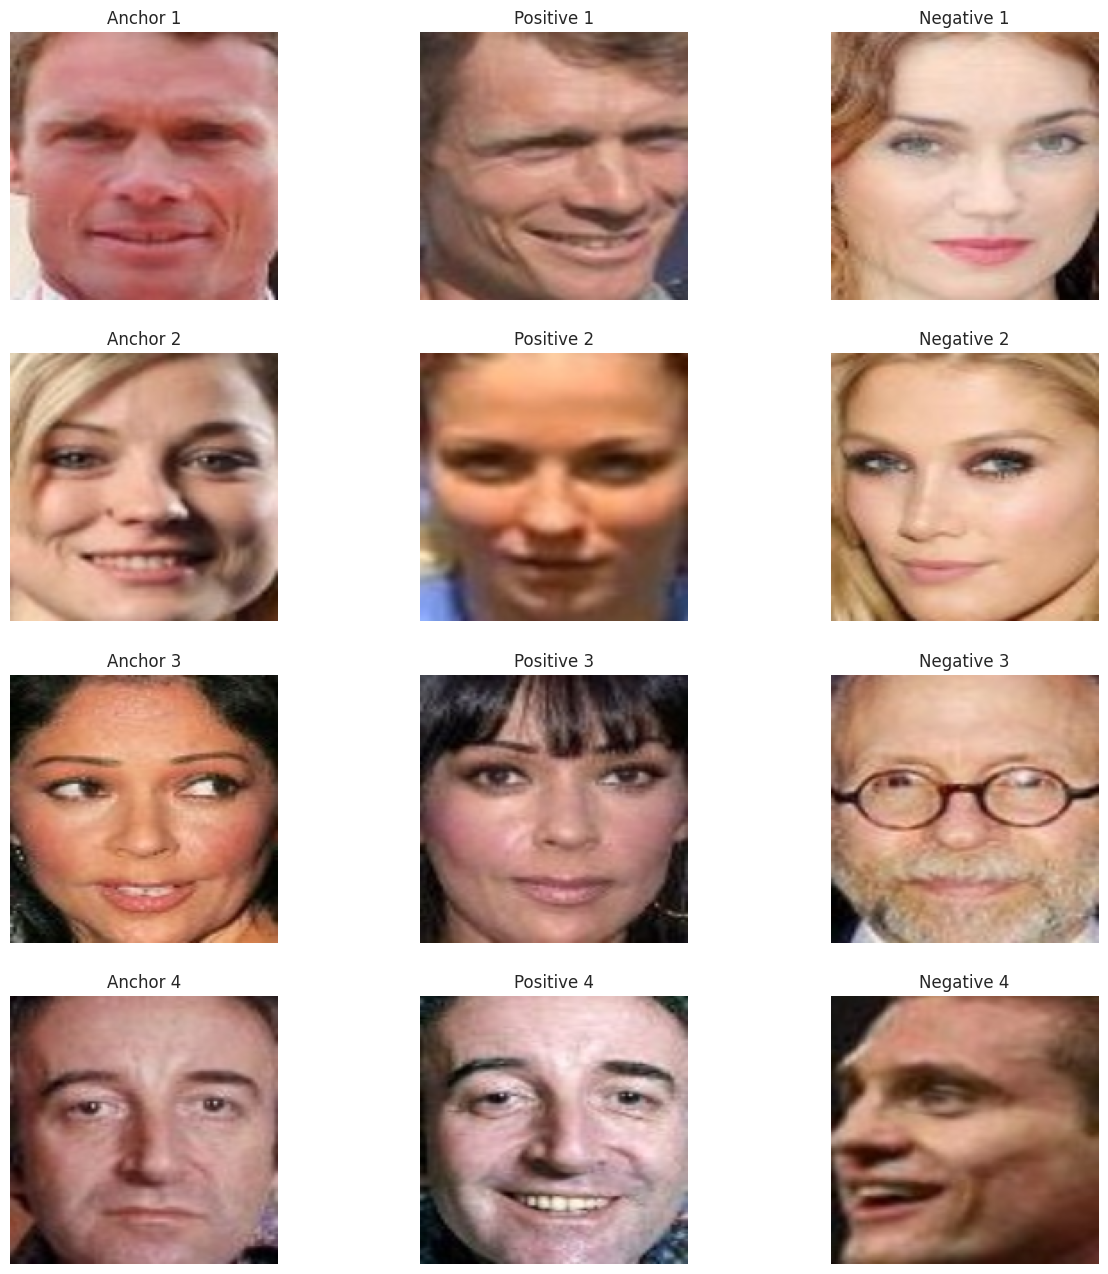

In [ ]:
plot_triplets(val_loader, num_triplets=4)

## Build Siamese Network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        # Load pretrained ResNet18 model
        self.feature_extractor = models.resnet18(pretrained=True)
        
        # Adjust first conv layer for smaller images (150x150)
        self.feature_extractor.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Remove fully connected layer
        self.feature_extractor.fc = nn.Identity()

        # Fully connected layers with BatchNorm and Swish activation
        self.fc = nn.Sequential(
            nn.Linear(512, 512),  # ResNet18 outputs 512 features
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, embedding_dim)  # Final embedding size
        )

        # Enable fine-tuning of all layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = True  # Allow training on all layers

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x  # Returns embedding vector
    

## Load Model

In [157]:
def load_model(model, optimizer, path="model.pth"):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Model loaded from {path}")
        return model, optimizer, epoch
    else:
        print("No saved model found, starting from scratch.")
        return model, optimizer, 0  # Start from epoch 0

## Model Saving

In [158]:
def save_model(model, optimizer, epoch, path="model.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Model saved to {path}")

## Train the Model

In [159]:
def compute_accuracy(anchor_out, positive_out, negative_out):
    """
    Computes accuracy as the percentage of correctly ranked triplets.
    A triplet is correct if d(anchor, positive) < d(anchor, negative).
    """
    pos_dist = F.pairwise_distance(anchor_out, positive_out)
    neg_dist = F.pairwise_distance(anchor_out, negative_out)
    
    correct = (pos_dist < neg_dist).sum().item()
    total = anchor_out.shape[0]  # Batch size
    return correct, total, pos_dist, neg_dist  # Return distances

In [160]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to stop training when the validation loss does not improve.
        
        Args:
        - patience (int): Number of epochs to wait before stopping if no improvement.
        - min_delta (float): Minimum change to be considered as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if improvement occurs
        else:
            self.counter += 1  # Increase counter if no improvement
            
        return self.counter >= self.patience  # Stop if patience limit is reached

In [ ]:
pos_distances = []  # Store positive distances for box plot
neg_distances = []  # Store negative distances for box plot

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cuda"):
    model.to(device)
    best_val_loss = float('inf')  # Initialize best validation loss

    # Define LR scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    
    early_stopping = EarlyStopping(patience=5, min_delta=0.0)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_correct, train_total = 0, 0  

        for anchors, positives, negatives in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Move images to device
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

            # Forward pass
            anchor_out = model(anchors)
            positive_out = model(positives)
            negative_out = model(negatives)

            # Compute Triplet Loss
            loss = criterion(anchor_out, positive_out, negative_out)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute Accuracy
            correct, total, _, _ = compute_accuracy(anchor_out, positive_out, negative_out)
            train_correct += correct
            train_total += total

        avg_train_loss = train_loss / len(train_loader)
        train_acc = (train_correct / train_total * 100) if train_total > 0 else 0  

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for anchors, positives, negatives in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

                # Forward pass
                anchor_out = model(anchors)
                positive_out = model(positives)
                negative_out = model(negatives)

                # Compute Triplet Loss
                loss = criterion(anchor_out, positive_out, negative_out)
                val_loss += loss.item()

                # Compute Accuracy + Store distances
                correct, total, _, _ = compute_accuracy(anchor_out, positive_out, negative_out)
                val_correct += correct
                val_total += total

        avg_val_loss = val_loss / len(val_loader)
        val_acc = (val_correct / val_total * 100) if val_total > 0 else 0  

        # Step the scheduler based on average validation loss
        scheduler.step(avg_val_loss)

        # Check early stopping
        if early_stopping(avg_val_loss):
            print("Early stopping triggered. Stopping training.")
            break  # Stop training
                
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_model(model, optimizer, epoch)

In [ ]:
# Define the Model
model = SiameseNetwork()

# Define loss function and optimizer
criterion = torch.nn.TripletMarginLoss(margin=1.5)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model, optimizer, start_epoch = load_model(model, optimizer)

No saved model found, starting from scratch.


In [ ]:
# # Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

Epoch 1/20 - Validation: 100%|██████████| 145/145 [00:14<00:00,  9.88it/s]


Epoch [1/20] - Train Loss: 0.7433 | Train Acc: 78.56% | Val Loss: 0.4606 | Val Acc: 87.83%
Model saved to model.pth


Epoch 2/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.26it/s]


Epoch [2/20] - Train Loss: 0.4255 | Train Acc: 88.47% | Val Loss: 0.4297 | Val Acc: 88.63%
Model saved to model.pth


Epoch 3/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 11.79it/s]


Epoch [3/20] - Train Loss: 0.3174 | Train Acc: 91.61% | Val Loss: 0.4022 | Val Acc: 89.67%
Model saved to model.pth


Epoch 4/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.21it/s]


Epoch [4/20] - Train Loss: 0.2410 | Train Acc: 93.72% | Val Loss: 0.3832 | Val Acc: 89.86%
Model saved to model.pth


Epoch 5/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.22it/s]


Epoch [5/20] - Train Loss: 0.1838 | Train Acc: 95.25% | Val Loss: 0.3901 | Val Acc: 90.03%


Epoch 6/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.18it/s]


Epoch [6/20] - Train Loss: 0.1384 | Train Acc: 96.43% | Val Loss: 0.4094 | Val Acc: 89.62%


Epoch 7/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 11.87it/s]


Epoch [7/20] - Train Loss: 0.1113 | Train Acc: 97.13% | Val Loss: 0.4269 | Val Acc: 89.43%


Epoch 8/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.14it/s]


Epoch [8/20] - Train Loss: 0.0981 | Train Acc: 97.45% | Val Loss: 0.4088 | Val Acc: 90.20%


Epoch 9/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.25it/s]


Epoch [9/20] - Train Loss: 0.0465 | Train Acc: 98.85% | Val Loss: 0.3705 | Val Acc: 90.64%
Model saved to model.pth


Epoch 10/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 11.85it/s]


Epoch [10/20] - Train Loss: 0.0269 | Train Acc: 99.35% | Val Loss: 0.3852 | Val Acc: 90.53%


Epoch 11/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.11it/s]


Epoch [11/20] - Train Loss: 0.0265 | Train Acc: 99.40% | Val Loss: 0.3775 | Val Acc: 90.74%


Epoch 12/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.25it/s]


Epoch [12/20] - Train Loss: 0.0239 | Train Acc: 99.46% | Val Loss: 0.3750 | Val Acc: 91.59%


Epoch 13/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.26it/s]


Epoch [13/20] - Train Loss: 0.0213 | Train Acc: 99.53% | Val Loss: 0.3966 | Val Acc: 90.74%


Epoch 14/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 11.68it/s]


Epoch [14/20] - Train Loss: 0.0121 | Train Acc: 99.75% | Val Loss: 0.3608 | Val Acc: 91.82%
Model saved to model.pth


Epoch 15/20 - Validation: 100%|██████████| 145/145 [00:11<00:00, 12.17it/s]


Epoch [15/20] - Train Loss: 0.0078 | Train Acc: 99.83% | Val Loss: 0.3746 | Val Acc: 91.87%


Epoch 16/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 12.05it/s]


Epoch [16/20] - Train Loss: 0.0070 | Train Acc: 99.84% | Val Loss: 0.4074 | Val Acc: 90.81%


Epoch 17/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 11.64it/s]


Epoch [17/20] - Train Loss: 0.0081 | Train Acc: 99.82% | Val Loss: 0.3908 | Val Acc: 91.24%


Epoch 18/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 11.27it/s]


Epoch [18/20] - Train Loss: 0.0073 | Train Acc: 99.85% | Val Loss: 0.4021 | Val Acc: 90.94%


Epoch 19/20 - Validation: 100%|██████████| 145/145 [00:12<00:00, 12.00it/s]

Early stopping triggered. Stopping training.


In [165]:
model.eval()
model.to(device)

with torch.no_grad():
    for anchors, positives, negatives in tqdm(val_loader):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

        # Forward pass
        anchor_out = model(anchors)
        positive_out = model(positives)
        negative_out = model(negatives)

        # Compute Accuracy + Store distances
        correct, total, pos_dist, neg_dist = compute_accuracy(anchor_out, positive_out, negative_out)

# Store distances for analysis
pos_distances.extend(pos_dist.cpu().numpy())
neg_distances.extend(neg_dist.cpu().numpy())

100%|██████████| 145/145 [00:13<00:00, 10.99it/s]


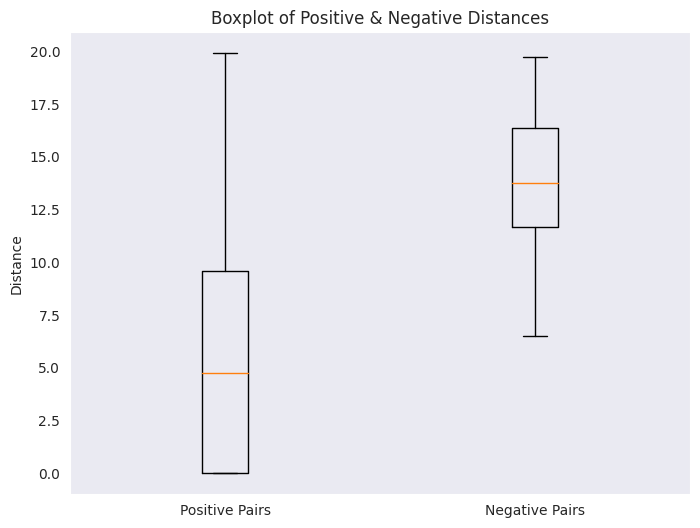

In [166]:
    # Plot Box Plot of Distances
    plt.figure(figsize=(8, 6))
    plt.boxplot([pos_distances, neg_distances], labels=['Positive Pairs', 'Negative Pairs'])
    plt.title("Boxplot of Positive & Negative Distances")
    plt.ylabel("Distance")
    plt.show()

From the box plot above, we can see that a threshold between 10 and 12 will be the best. I will choose the threshold to be 11.

## Extract Face Embeddings

In [ ]:
model, optimizer, start_epoch = load_model(model, optimizer, path='/kaggle/input/siamese-network/pytorch/default/1/model.pth')

Model loaded from /kaggle/input/siamese-network/pytorch/default/1/model.pth


In [168]:
def get_embedding(image_path, model, device="cuda"):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dim
    
    with torch.no_grad():  # No gradients needed for inference
        embedding = model(image).cpu().numpy().flatten()  # Convert to NumPy

    return embedding

In [169]:
# Folder containing face images
folder_path = "/kaggle/input/lfw-facial-recognition/Face Recognition/Detected Faces"
output_file = "/kaggle/working/celebrity_embeddings.pkl"

# Standardize names for database storage
def standardize_name(filename):
    name = os.path.splitext(filename)[0]  # Remove extension
    name = re.sub(r'_\d+$', '', name)  # Remove numeric suffix
    name = name.replace('_', ' ')  # Convert underscores to spaces
    return name

# Initialize database
embeddings_dict = {}

model.to(device)
model.eval()

for i, filename in enumerate(os.listdir(folder_path)):
    if i >= 10:  # Stop after 10 images
        break
    file_path = os.path.join(folder_path, filename)

    if os.path.isfile(file_path):  # Ensure it's a file
        person_name = standardize_name(filename)  # Get standardized name

        # Extract embedding
        embedding = get_embedding(file_path, model, device)
        embeddings_dict[person_name] = embedding  # Save in dictionary

# Save embeddings to file
with open(output_file, "wb") as f:
    pickle.dump(embeddings_dict, f)

print(f"🎯 Embeddings saved in {output_file}")

🎯 Embeddings saved in /kaggle/working/celebrity_embeddings.pkl


In [170]:
import pickle

# Load embeddings
with open("celebrity_embeddings.pkl", "rb") as f:
    embeddings_dict = pickle.load(f)

# Convert dictionary to tensors
names = list(embeddings_dict.keys())
print(names[:10])   # Get some names to test the model on

database_embeddings = torch.tensor(np.array(list(embeddings_dict.values())))  # Shape: (num_faces, embedding_dim)
database_embeddings.shape


['Jennifer Garner', 'Robert McKee', 'Antonio Banderas', 'Sarah Canale', 'Amelia Vega', 'Susan Walvius', 'Tubby Smith', 'Peter Bacanovic', 'Eric Clapton', 'Vicente Fernandez']


torch.Size([10, 128])

## Face Detector for Cropping Images

In [ ]:
# Load face detector (MTCNN)
detector = MTCNN()

## Face Embedding Matching

In [172]:
def recognize_faces(image_folder, model, database_embeddings, names, save_folder="output_faces", device="cuda", threshold=10.0):
    """
    Detects faces in images using MTCNN, extracts embeddings, and matches with the database.
    """
    model.eval()
    model.to(device)

    os.makedirs(save_folder, exist_ok=True)  # Ensure save directory exists

    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        img_cv = cv2.imread(img_path)  # OpenCV format for annotation

        # Detect faces using MTCNN
        faces = detector.detect_faces(img_cv)

        if not faces:
            print(f"⚠️ No face detected in {img_name}")
            continue  # Skip this image

        for i, face in enumerate(faces):
            x1, y1, width, height = face['box']
            x2, y2 = x1 + width, y1 + height

            # Crop face
            face = img.crop((x1, y1, x2, y2))

            # Transform and get embedding
            face_tensor = transform(face).unsqueeze(0).to(device)
            with torch.no_grad():
                new_embedding = model(face_tensor).cpu().numpy().flatten()

            new_embedding = torch.tensor(new_embedding).to(device).unsqueeze(0)

            # Compute distances with database
            distances = F.pairwise_distance(database_embeddings.to(device), new_embedding)

            # Find best match
            min_dist, min_idx = torch.min(distances, dim=0)
            min_dist = min_dist.item()

            if min_dist < threshold:
                recognized_name = names[min_idx.item()]
                print(f"✅ Match: {recognized_name} (Distance: {min_dist:.2f})")
            else:
                recognized_name = "Unknown"
                print(f"❌ No match (Distance: {min_dist:.2f})")

            # Annotate image
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_cv, recognized_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Save annotated image
        save_path = os.path.join(save_folder, f"annotated_{img_name}")
        cv2.imwrite(save_path, img_cv)
        print(f"📸 Saved: {save_path}")

## Face Recognition System

In [173]:
# Path to a new image
new_image_path = "/kaggle/input/testing-images"

# Recognize the person
recognized_name = recognize_faces(new_image_path, model, database_embeddings, names, device=device, threshold=11)

✅ Match: Peter Bacanovic (Distance: 5.86)
📸 Saved: output_faces/annotated_image2.jpg
✅ Match: Jennifer Garner (Distance: 7.65)
📸 Saved: output_faces/annotated_image1.jpg
✅ Match: Susan Walvius (Distance: 5.35)
📸 Saved: output_faces/annotated_image6.jpg
✅ Match: Amelia Vega (Distance: 5.62)
📸 Saved: output_faces/annotated_image5.jpg


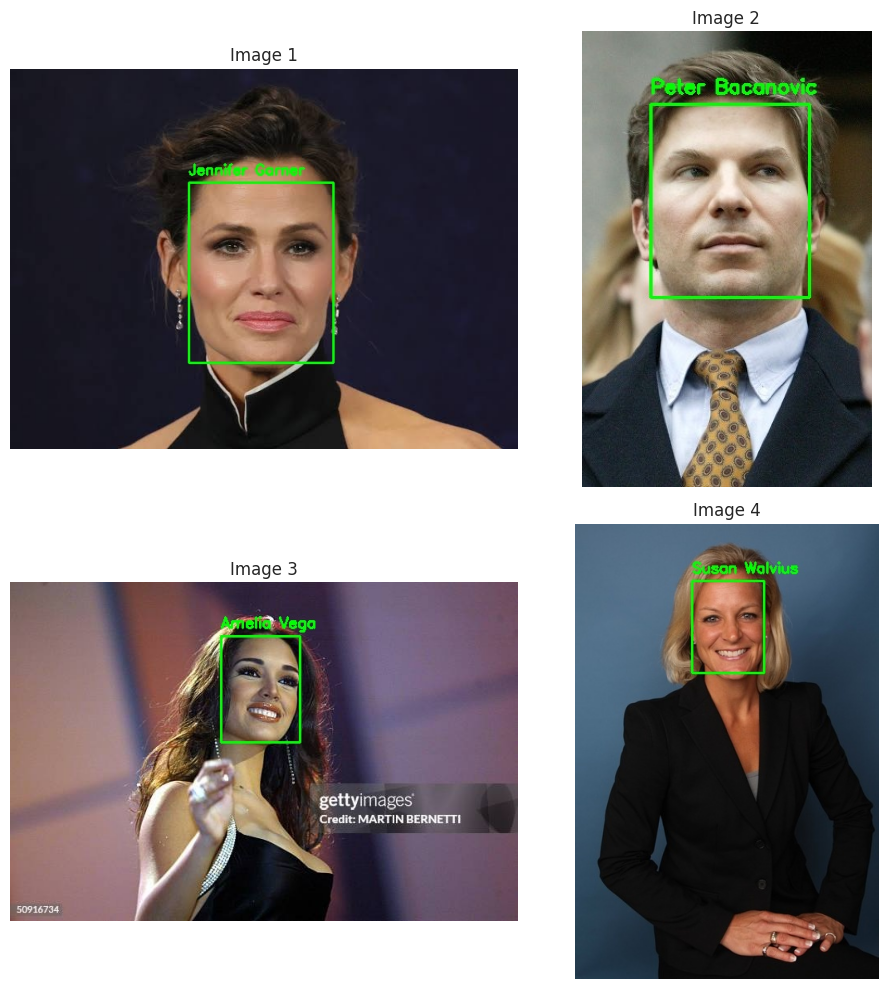

In [174]:
# Load and display the 4 images (2x2)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

# List the annotated images
output_folder = "/kaggle/working/output_faces"
annotated_images = sorted(os.listdir(output_folder))[:4]  # Ensure only 4 images

for i, img_name in enumerate(annotated_images):
    img_path = os.path.join(output_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from OpenCV BGR to RGB
    
    ax = axes[i // 2, i % 2]  # Position in the 2x2 grid
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()